# Loading the data

In [1]:
import pandas as pd
import os

TITANIC_FOLDER_PATH = path = os.path.join("datasets", "titanic")


def load_titanic_data(filename):
    file_path = os.path.join(TITANIC_FOLDER_PATH, filename)
    return pd.read_csv(file_path)

In [2]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
gender_submission_data = load_titanic_data("gender_submission.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Ok, we have the data. The test set does not have a label. That's meant to run your model on it and make the submissions and see the result.

# Explore the data

Does the dataset have empty values?

In [4]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.isna().sum() / len(train_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

There are empty values. Almost 20% of age, 77% of Cabin and 0.02 % of Embarked. Let's check closer.


In [6]:
train_data["Age"].value_counts()


24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [7]:
train_data["Cabin"].value_counts()


B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Cabin seems to be a categorical value. Doesn't help a lot since there are a lot of values. But what if we just keep the cabin number? Like A, B, C, D ? Maybe we could engineer that feature.

In [8]:
train_data["Embarked"].value_counts()


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Just 3 categories here representing 3 different embarking locations. The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

## Let's check how many passengers survived

In [9]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
train_data["Survived"].value_counts(normalize=True)


0    0.616162
1    0.383838
Name: Survived, dtype: float64

<AxesSubplot:>

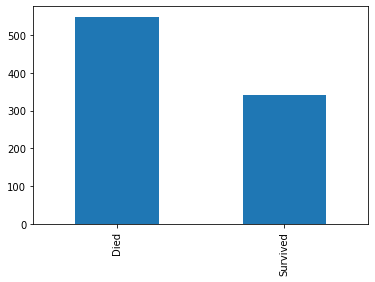

In [11]:
survived_data = train_data["Survived"].value_counts()
survived_data.index = ["Died", "Survived"]
survived_data.plot(kind="bar")

I'll create a method to plot different dataframes based on survival since i'll need this later

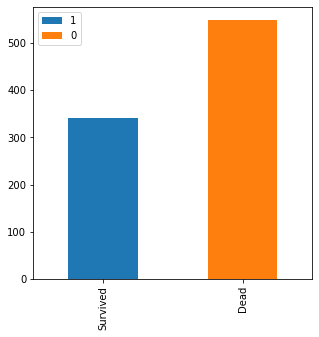

In [12]:
def survival_chart_stacked(data, feature, stacked=True):
    survived = data[data["Survived"] == 1][feature].value_counts()
    dead = data[data["Survived"] == 0][feature].value_counts()
    survived_dead = pd.DataFrame([survived, dead])
    survived_dead.index = ["Survived", "Dead"]
    survived_dead.plot(kind="bar", stacked=stacked, figsize=(5,5))
survival_chart_stacked(train_data, "Survived")

So yea, 38% only survived. The data set suffers from imbalance but this imbalance is important, so we shouldn't sample it.

## Is the likelihood of survival dependent on gender?

In [13]:
train_data["Sex"].value_counts()


male      577
female    314
Name: Sex, dtype: int64

In [14]:
train_data["Sex"].value_counts(normalize=True)


male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [15]:
train_data.groupby("Sex")["Survived"].mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

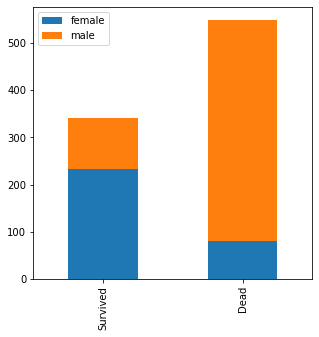

In [16]:
survival_chart_stacked(train_data, "Sex")


It's clear here that the majority of people who survived were women. 4 times higher that the survival rate for men. It confirms that they  applied the women and children first.

## Is the likelihood of survival dependent on class?

In [17]:
train_data["Pclass"].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [18]:
train_data.groupby("Pclass")["Survived"].mean()


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

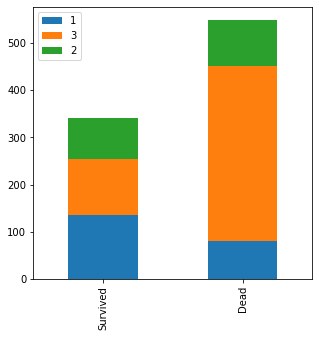

In [19]:
survival_chart_stacked(train_data, "Pclass")


The class seems to be relevant. Most of the passengers (55%) had class 3 tickets but only 24% of them survived. 63% of class 1 survived which is very relevant and 47% of class 2.